In [2]:
# Import modules 
import os
import string
from utils import model_utils
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.text import Tokenizer
from pickle import dump, load
import numpy as np

from keras.layers import Flatten
# Decoder model imports
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from numpy import array, prod
from keras.callbacks import ModelCheckpoint

#plot curve
import matplotlib.pyplot as plt
%inline matplotlib

Using TensorFlow backend.
D:\ProgramFiles\Anaconda3\envs\keras_tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\ProgramFiles\Anaconda3\envs\keras_tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\ProgramFiles\Anaconda3\envs\keras_tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\ProgramFiles\Anacond

In [3]:
# File split for train, test and validation
if not ((os.path.exists('train.pkl')) and (os.path.exists('valid.pkl')) and (os.path.exists('test.pkl'))):
    train_path = r'..\Flickr8k\Flickr8k_text\Flickr_8k.devImages.txt'
    test_path = r'..\Flickr8k\Flickr8k_text\Flickr_8k.trainImages.txt'
    valid_path = r'..\Flickr8k\Flickr8k_text\Flickr_8k.testImages.txt'
    paths = []
    for path in [train_path, valid_path, test_path]:
        with open(path, 'r') as fh:
            paths = paths + fh.readlines()
    sample_idx = np.random.choice(len(paths), size=int(len(paths)), replace=False)

    # Train Set 80% of the data
    train_set = [paths[idx].strip('\n').split('.')[0] for idx in sample_idx[:int(len(sample_idx)*.80)]]
    valid_set = [paths[idx].strip('\n').split('.')[0] for idx in sample_idx[int(len(sample_idx)*.80):int(len(sample_idx)*.90)]]
    test_set = [paths[idx].strip('\n').split('.')[0] for idx in sample_idx[int(len(sample_idx)*.90):]]
    dump(train_set, open('train.pkl', 'wb'))
    dump(valid_set, open('valid.pkl', 'wb'))
    dump(test_set, open('test.pkl', 'wb'))
else:
    train_set = load(open('train.pkl', 'rb'))
    valid_set = load(open('valid.pkl', 'rb')) 
    test_set = load(open('test.pkl', 'rb'))

In [4]:
def initiate_encoder(arch='capsnet'):
    """
        Description: Initiate the encoder 
        :arch: 'capsnet' or 'vgg'
    """
    if arch=='capsnet':
        encoder_model = model_utils.load_DeepCapsNet(input_shape=(64,64,3), n_class=10, routings=3, \
                        weights=r'weights\deep_caps_best_weights.h5')
    else:
        encoder_model = model_utils.load_VGG()
    return encoder_model

In [5]:
def extract_features(model, directory, arch, path):
    """
        Description: Function to extract features through the model
        :model: The model object
        :directory: Path of the directory of images
        :path: Path to save the file
    """
    features = dict()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    print('Feature extraction started')
    for name in os.listdir(directory):
        image_path = directory + '/' + name
        target_size = (64,64) if arch=='capsnet' else (224,224)
        try:
            image = load_img(image_path, target_size=target_size)
        except:
            print('{} could not be opened. Skipping'.format(image_path))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # Extract the features from the last layer
        if arch=='capsnet':
            feature = model.predict(image, verbose=0).reshape(-1, 10*32)
        else:
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        # Populate the dictionary
        features[image_id] = feature
    path = os.path.join(path, 'features_{}.pkl'.format(arch))
    dump(features, open(path, 'wb'))
    print('Features extracted and stored at {}'.format(path))
    return

In [6]:
img_dir = r'..\Flickr8k\Flicker8k_Dataset'
arch = 'vgg'
encoder_model = initiate_encoder(arch=arch)
if not os.path.exists('features_{}.pkl'.format(arch)):
    extract_features(encoder_model, img_dir, arch, r'..\Flickr8k_image_captioning_using_CapsNet')

Instructions for updating:
Colocations handled automatically by placer.
Complete Capsule Architecture
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
________________________________________

In [9]:
def read_files(filename):
    """
        Description: Generic function to read files and return contents
        :filename: Path of the files
    """
    with open(filename, 'r') as fh:
        content = fh.readlines()
    return ''.join(content)

In [10]:
# Load and clean descriptions of the images
def map_descriptions(desc_content):
    """
        Description: Map the descriptions <image>:[description_list]
        :desc_content: File content
    """
    # Each image contains 5 descriptions in the format
    # <image_name>#<1-5> sentence
    mapping = dict()
    lines = list()
    for line in desc_content.split('\n'):
        if len(line) < 2:
            continue
        tokens = line.split()
        image_id, image_desc = tokens[0], ' '.join(tokens[1:])
        image_id = image_id.split('.')[0]
        table = str.maketrans('', '', string.punctuation)
        image_desc = image_desc.split()
        image_desc = [word.lower() for word in image_desc]
        image_desc = [w.translate(table) for w in image_desc]
        image_desc = [word for word in image_desc if (len(word)>1 and word.isalpha())]
        if image_id not in mapping:
            mapping[image_id] = list()
        # Append the list of the dictionary
        clean_desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        mapping[image_id].append(clean_desc)
        lines.append(image_id+' '+clean_desc)
    # Write the files to a clean description file
    with open('descriptions.txt', 'w') as fh:
        fh.writelines('\n'.join(lines))
    return mapping

def to_vocabulary(descriptions):
    """
    Description: Build the vocabulary from the complete set
    :descriptions: Get the mappings of the dataset
    """
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

In [11]:
filename = r'..\Flickr8k\Flickr8k_text\Flickr8k.token.txt'
doc = read_files(filename)
descriptions = map_descriptions(doc)
print('Total Desciptions: %d ' % len(descriptions))
vocabulary = to_vocabulary(descriptions)
print('Total Vocabulary: %d' % len(vocabulary))

Total Desciptions: 8092 
Total Vocabulary: 8765


### Preparaing Training Set
* The dataset contains multiple files inside Flickr8k_text. The 8000 images are divided into:
    * Training Set: 6400
    * Validation Set: 800
    * Test Set: 800
* The images names for the training names are stored in the Flickr_8k.trainImages.txt.

In [12]:
print("Size of Training dataset: {}".format(len(set(train_set))))

Size of Training dataset: 6400


In [13]:
def create_tokenizer(descriptions):
    """
    Description: Tokenize the description
    """
    all_desc = list()
    for _, desc in descriptions.items():
        [all_desc.append(d) for d in desc]
    tokenizer = Tokenizer()
    max_length = max([len(desc.split()) for desc in all_desc])
    tokenizer.fit_on_texts(all_desc)
    dump(tokenizer, open('tokenizer.pkl', 'wb'))
    return tokenizer, max_length

In [14]:
# Load the training descriptions
train_desc = {image_id:desc for image_id, desc in descriptions.items() if image_id in train_set}
# Tokenize the the train description
train_tokenizer, max_length = create_tokenizer(train_desc)
# Get the features of training dataset
feature_path = "features_{}.pkl".format(arch)
# feature_path = "features_VGG.pkl"
all_features = load(open(feature_path, 'rb'))
train_features = {image_id:feat for image_id, feat in all_features.items() if image_id in train_set}

In [15]:
vocab_size = len(train_tokenizer.word_index) + 1
print('Vocabulary Size: {}\nMaximum Legth: {}\nloaded photo features: {}'\
      .format(vocab_size, max_length, len(train_features)))

Vocabulary Size: 7864
Maximum Legth: 34
loaded photo features: 6400


In [16]:
val_features = {image_id:feat for image_id, feat in all_features.items() if image_id in valid_set}
val_desc = {image_id:desc for image_id, desc in descriptions.items() if image_id in valid_set}

In [2]:
def define_model(encoder_shape, vocab_size, max_length):
    """
    Description: Define the decoder model
    :encoder_shape: Input from the image feature
    :vocab_size: 
    :max_length: maximum length of the description
    """
    # Image Encoder
    inputs1 = Input(shape=(None, encoder_shape))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    encoder, state_h, state_c = LSTM(256, return_state=True)(fe2)
    encoder_states = [state_h, state_c]
    # Text encoder
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    # SeqToSeq Word Model
    decoder1,_,_ = LSTM(256, return_sequences=True, return_state=True)(se2, initial_state=encoder_states)
    nonmasking = model_utils.NonMasking()(decoder1)
    flatten1 = Flatten()(nonmasking)
    decoder2 = Dense(256, activation='relu')(flatten1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    model.summary()
    return model

In [7]:
encoder_op_shape = prod(list(filter(None, encoder_model.layers[-1].output.shape.as_list())))
model = define_model(encoder_op_shape, vocab_size, max_length)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, 320)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 320)    0           input_3[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      2013184     input_4[0][0]               

In [19]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    """
    Description: Create seqences for input <photo>, <description>, <output>
    """
    X1, X2, y = list(), list(), list()
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(np.expand_dims(photo, axis=0))
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    while 1:
        for key, desc_list in descriptions.items():
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield [[in_img, in_seq], out_word]

In [25]:
# Train model for VGG
epochs = 10
train_steps = len(train_desc)
val_steps = len(val_desc)
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}_VGG_init.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    # create the data generator
train_generator = data_generator(train_desc, train_features, train_tokenizer, max_length, vocab_size)
valid_generator = data_generator(val_desc, val_features, train_tokenizer, max_length, vocab_size)
# fit for one epoch
history = model.fit_generator(train_generator, epochs=10, steps_per_epoch=train_steps, verbose=1, validation_data=valid_generator,\
                        validation_steps=val_steps, callbacks=[checkpoint])

Epoch 1/10
6400/6400 [==============================] - 512s 80ms/step - loss: 4.7760 - val_loss: 4.3206

Epoch 00001: val_loss improved from inf to 4.32059, saving model to model-ep001-loss4.794-val_loss4.321_VGG_init.h5


D:\ProgramFiles\Anaconda3\envs\keras_tf_gpu\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
6400/6400 [==============================] - 555s 87ms/step - loss: 4.2004 - val_loss: 4.1759

Epoch 00002: val_loss improved from 4.32059 to 4.17592, saving model to model-ep002-loss4.218-val_loss4.176_VGG_init.h5
Epoch 3/10
6400/6400 [==============================] - 663s 104ms/step - loss: 4.0318 - val_loss: 4.1611

Epoch 00003: val_loss improved from 4.17592 to 4.16110, saving model to model-ep003-loss4.048-val_loss4.161_VGG_init.h5
Epoch 4/10
6400/6400 [==============================] - 685s 107ms/step - loss: 3.9389 - val_loss: 4.1107

Epoch 00004: val_loss improved from 4.16110 to 4.11073, saving model to model-ep004-loss3.955-val_loss4.111_VGG_init.h5
Epoch 5/10
6400/6400 [==============================] - 690s 108ms/step - loss: 3.8862 - val_loss: 4.1125

Epoch 00005: val_loss did not improve from 4.11073
Epoch 6/10
6400/6400 [==============================] - 507s 79ms/step - loss: 3.8448 - val_loss: 4.1298

Epoch 00006: val_loss did not improve from 4.11073
Epoch

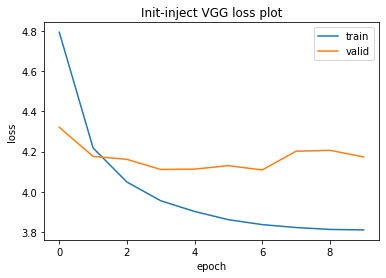

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Init-inject VGG loss plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [20]:
# Train model for CapsNet
epochs = 10
train_steps = len(train_desc)
val_steps = len(val_desc)
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}_CapsNet_init.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
train_generator = data_generator(train_desc, train_features, train_tokenizer, max_length, vocab_size)
valid_generator = data_generator(val_desc, val_features, train_tokenizer, max_length, vocab_size)
# fit for one epoch
history = model.fit_generator(train_generator, epochs=10, steps_per_epoch=train_steps, verbose=1, validation_data=valid_generator,\
                        validation_steps=val_steps, callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
6400/6400 [==============================] - 679s 106ms/step - loss: 4.6740 - val_loss: 4.1357

Epoch 00001: val_loss improved from inf to 4.13566, saving model to model-ep001-loss4.691-val_loss4.136_CapsNet_init.h5


D:\ProgramFiles\Anaconda3\envs\keras_tf_gpu\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
6400/6400 [==============================] - 697s 109ms/step - loss: 3.9052 - val_loss: 3.9655

Epoch 00002: val_loss improved from 4.13566 to 3.96545, saving model to model-ep002-loss3.920-val_loss3.965_CapsNet_init.h5
Epoch 3/10
6400/6400 [==============================] - 708s 111ms/step - loss: 3.6292 - val_loss: 3.9363

Epoch 00003: val_loss improved from 3.96545 to 3.93628, saving model to model-ep003-loss3.643-val_loss3.936_CapsNet_init.h5
Epoch 4/10
6400/6400 [==============================] - 612s 96ms/step - loss: 3.4445 - val_loss: 3.9531

Epoch 00004: val_loss did not improve from 3.93628
Epoch 5/10
6400/6400 [==============================] - 495s 77ms/step - loss: 3.3084 - val_loss: 3.9972

Epoch 00005: val_loss did not improve from 3.93628
Epoch 6/10
6400/6400 [==============================] - 488s 76ms/step - loss: 3.2029 - val_loss: 4.0510

Epoch 00006: val_loss did not improve from 3.93628
Epoch 7/10
6400/6400 [==============================] - 495s 77ms/s

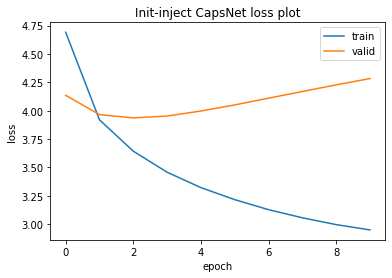

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Init-inject CapsNet loss plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### Validation using BLEU score

In [22]:
# Import statement to instantiate the models
from utils import model_utils
# Import statements for other calculations
from pickle import load
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu
from numpy import array
from math import log

In [23]:
def generate_desc_beam_search(model, tokenizer, photo, max_length, beam_length=1):
    """
    Description: This function can be used to create description
    :model: The decoder model object
    :tokenizer: The tokenizer object used to get the words from predicted indexes
    :max_length: The maximum length of the sentence to be generated
    :beam_length: Length to check conditional probability. 
                1: for greedy search
                1+: For beam search
    """
    in_text = 'startseq'
    beam_list = list()
    for i in range(max_length):
        if not beam_list:
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=max_length)
            yhat = model.predict([photo,sequence], verbose=0).squeeze()
            yhat_idx = yhat.argsort()[-beam_length:]
            for idx in yhat_idx:
                word = tokenizer.index_word[idx]
                in_text += ' ' + word
                beam_list.append((in_text, log(yhat[idx])))
        else:
            combination_list = list()
            for elems in beam_list:
                if elems[0].endswith('endseq'):
                    combination_list.append(elems)
                    continue
                in_text = elems[0]
                sequence = tokenizer.texts_to_sequences([in_text])[0]
                sequence = pad_sequences([sequence], maxlen=max_length)
                yhat = model.predict([photo,sequence], verbose=0).squeeze()
                yhat_idx = yhat.argsort()[-beam_length:]
                for idx in yhat_idx:
                    word = tokenizer.index_word[idx]
                    if word is None:
                        continue
                    in_text += ' ' + word
                    combination_list.append((in_text, elems[1]*log(yhat[idx])))
            probs = array([combinations[1] for combinations in combination_list])
            top_idx = probs.argsort()[-beam_length:]
            for i, idx in enumerate(top_idx):
                beam_list[i] = combination_list[idx]
    probs = array([prob[1] for prob in beam_list])
    top_idx = argmax(probs)        
    return beam_list[top_idx][0]

In [24]:
def get_BLEU(model, test_desc, photo_feature, tokenizer, max_length, beam_length=1):
    """
    Decription: This function can be used to evaluate BLEU score of the model word by word
    :model: The Decoder model
    :test_desc: test description
    :photo_feature: Extracted features of photos
    :tokenizer: Tokenizer object
    :max_length: Maximum length of the expected sentence
    :beam_length: Beam Length for beam search
    """
    actual, predicted = list(), list()
    count = 0
    for key, desc_list in test_desc.items():
        yhat = generate_desc_beam_search(model, tokenizer, photo_feature[key], max_length, beam_length)
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

### BLEU Score on the extracted features by VGG16

In [30]:
# Load the tokenizer model
tokenizer = load(open('tokenizer.pkl', 'rb'))
features = 'features_vgg.pkl'
all_features = load(open(features, 'rb'))
test_features = {image_id: np.expand_dims(feat, axis=0) for image_id, feat in all_features.items() if image_id in test_set}
test_desc = {image_id:desc for image_id, desc in descriptions.items() if image_id in test_set}

In [32]:
### Get the BLEU score VGG extracted features with beam length 1
vgg_decoder_path = "model-ep007-loss3.836-val_loss4.108_VGG_init.h5"
test_model = define_model(encoder_op_shape, vocab_size, max_length)
test_model.load_weights(vgg_decoder_path)
beam_length = 1
get_BLEU(model, test_desc, test_features, tokenizer, max_length, beam_length)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, None, 4096)   0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, None, 4096)   0           input_8[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 34, 256)      2013184     input_9[0][0]                    
__________________________________________________________________________________________________
dense_10 (

In [33]:
# Beam length 2
beam_length = 2
get_BLEU(test_model, test_desc, test_features, tokenizer, max_length, beam_length)

BLEU-1: 0.288492
BLEU-2: 0.102407
BLEU-3: 0.045346
BLEU-4: 0.006545


### BLEU Score on the extracted features by Capsule Network

In [25]:
# Load the tokenizer model
tokenizer = load(open('tokenizer.pkl', 'rb'))
features = 'features_capsnet.pkl'
all_features = load(open(features, 'rb'))
test_features = {image_id: np.expand_dims(feat, axis=0) for image_id, feat in all_features.items() if image_id in test_set}
test_desc = {image_id:desc for image_id, desc in descriptions.items() if image_id in test_set}

In [27]:
capsnet_decoder_path = "model-ep003-loss3.643-val_loss3.936_CapsNet_init.h5"
beam_length = 1
test_model = define_model(encoder_op_shape, vocab_size, max_length)
test_model.load_weights(capsnet_decoder_path)
get_BLEU(test_model, test_desc, test_features, tokenizer, max_length, beam_length)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, None, 320)    0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 34)           0                                            
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, None, 320)    0           input_9[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 34, 256)      2013184     input_10[0][0]                   
__________________________________________________________________________________________________
dense_9 (D

In [28]:
# Beam length 2
beam_length = 2
get_BLEU(test_model, test_desc, test_features, tokenizer, max_length, beam_length)

BLEU-1: 0.375935
BLEU-2: 0.124800
BLEU-3: 0.057325
BLEU-4: 0.011984


### Inference

In [ ]:
def extract_feature(model, arch, image_path):
    """
    Description: Extract features for a given image
    :model: The Encoder model
    :arch: The arch type
    :image_path: Path to the image
    """
    feature = None
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    target_size = (64,64) if arch=='capsnet' else (224,224)
    try:
        image = load_img(image_path, target_size=target_size)
    except Exception as e:
        print('{} could not be opened. Skipping\n {}'.format(image_path,e))
        return None
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    if arch=='capsnet':
        feature = model.predict(image, verbose=0).reshape(-1, 10*32)
    else:
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
    return feature

In [ ]:
arch = 'capsnet'
encoder_model = initiate_encoder(arch)
# Extract features of the image
image_path = r'C:\Users\jayde\OneDrive\Desktop\247778426_fd59734130.jpg'
photo_feature = extract_feature(encoder_model, arch, image_path)
max_length = 34
# Load the tokenizer model
tokenizer = load(open('tokenizer.pkl', 'rb'))
# Load the decoder model
decoder_path = r''
test_model = model.load_weights(decoder_path)
# Beam Search length
beam_length = 1
print(generate_desc_beam_search(test_model, tokenizer, photo_feature, max_length, beam_length))